In [3]:
import pandas as pd
import numpy as np

In [4]:
df_q=pd.read_csv('texts_q', index_col=0)
df_q.drop_duplicates(inplace=True)
df_q=df_q.iloc[:, 0].tolist()
print(len(df_q))

314


In [5]:
df_rs=pd.read_csv('texts_rs', index_col=0)
df_rs.drop_duplicates(inplace=True)
df_rs=df_rs.iloc[:, 0].tolist()
print(len(df_rs))

539


### Cleaning text with Spacy

In [6]:
!pip install spacy
!python -m spacy download en_core_web_md
import spacy
model = spacy.load('en_core_web_md')

def cleaning_function(text):
    clean_text = []
    token_text = model(text)
    for word in token_text:
        if not word.is_stop and not word.is_punct and word.is_alpha:
            clean_text.append(word.lemma_)
    return ' '.join(clean_text)

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [7]:
texts_queen_cl = []
for i in df_q:
    i = cleaning_function(i)
    texts_queen_cl.append(i)

In [8]:
df_q_cl = pd.DataFrame()
df_q_cl['SONGS'] = texts_queen_cl
df_q_cl.rename(columns={'0':'SONGS'}, inplace=True)
df_q_cl['ARTIST_Queen/Rollingstones_0/1'] = '0'

In [9]:
texts_rollingst_cl = []
for i in df_rs:
    i = cleaning_function(i)
    texts_rollingst_cl.append(i)

In [10]:
df_rs_cl = pd.DataFrame()
df_rs_cl['SONGS'] = texts_rollingst_cl
df_rs_cl.rename(columns={'0':'SONGS'}, inplace=True)
df_rs_cl['ARTIST_Queen/Rollingstones_0/1'] = '1'
df = df_q_cl.append(df_rs_cl)
df.to_csv('songs_qrs_cl')
print(df.shape)

(853, 2)


In [11]:
df = pd.read_csv('songs_qrs_cl')
df.head()

,Unnamed: 0,SONGS,ARTIST_Queen/Rollingstones_0/1
0,0,ooh ooh sun hang sky desert sand wave crash se...,0
1,1,oh oh fool fool fool fool fool fool fool fool ...,0
2,2,Woh ow oh yeah touch afraid burn foot high spe...,0
3,3,anybody find somebody love ooh morning die lit...,0
4,4,yesterday life ruin today know get to feeling ...,0


### Train-test split

In [12]:
X = df['SONGS']
y = df['ARTIST_Queen/Rollingstones_0/1']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Count Vectorizer and tfidf Transfomer

In [14]:
def fit_transfrom(df):

    from sklearn.feature_extraction.text import TfidfVectorizer
    tfv = TfidfVectorizer(stop_words='english')
    tfv.fit(X_train) # Fit on X_train only
    tfv_corpus = tfv.transform(df)
    df_final = pd.DataFrame(tfv_corpus.todense().round(2), columns=tfv.get_feature_names())

    return df_final

In [15]:
X_train_fe = fit_transfrom(X_train)
X_test_fe = fit_transfrom(X_test)

### Class imbalance - over sampling

In [16]:
y_train.value_counts()

1    401
0    238
Name: ARTIST_Queen/Rollingstones_0/1, dtype: int64

In [17]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_fe, y_train) #.fit(X_resampled, y_resampled)

# we have a balanced training dataset now
print(y_resampled.value_counts(normalize=True))

1    0.5
0    0.5
Name: ARTIST_Queen/Rollingstones_0/1, dtype: float64


### Ensemble models / VotingClassifier 

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

models = [
          ('logreg', LogisticRegression()),
          ('nb', MultinomialNB()),
          ('svm', SVC(kernel='rbf'))
]
m = VotingClassifier(models,voting='hard')

m.fit(X_resampled, y_resampled)

VotingClassifier(estimators=[('logreg',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('nb',
                              MultinomialNB(alpha=1.0, class_prior=None,
                                            fit_prior=True)),
                             ('svm',
                              SVC(C=1.0, break_ties=False, cache_size=200,
   

In [19]:
from sklearn.metrics import accuracy_score
y_pred=m.predict(X_test_fe)
accuracy_score(y_pred, y_test)

0.8551401869158879

In [20]:
m.score(X_train_fe, y_train)

0.971830985915493

In [21]:
m.score(X_test_fe, y_test)

0.8551401869158879

### RandomForest

In [22]:
from sklearn.ensemble import RandomForestClassifier
m_rfc=RandomForestClassifier()
m_rfc.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
from sklearn import metrics
y_pred_rfc=m_rfc.predict(X_test_fe)
accuracy_score(y_pred_rfc, y_test)

0.8644859813084113

In [24]:
m_rfc.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

No handles with labels found to put in legend.


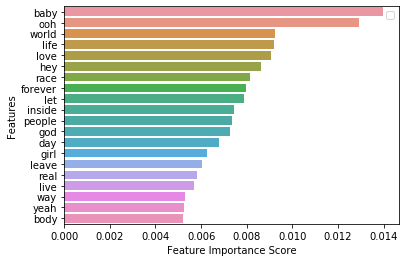

In [25]:
features = pd.Series(m_rfc.feature_importances_,index=X_train_fe.columns).sort_values(ascending=False).head(20)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.barplot(x=features, y=features.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.legend()
plt.show()

### SVM

In [26]:
from sklearn.svm import SVC

m_svm = SVC(kernel='rbf', C=0.1)
m_svm.fit(X_resampled, y_resampled)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
m_svm.score(X_train_fe, y_train)

In [ ]:
m_svm.score(X_test_fe, y_test)

In [ ]:
from sklearn import metrics
y_pred_svm=m_svm.predict(X_test_fe)
accuracy_score(y_pred_svm, y_test)

### Bayesian classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB

m_nb = MultinomialNB()
m_nb.fit(X_resampled, y_resampled)

In [ ]:
m_nb.score(X_train_fe, y_train)

In [ ]:
m_nb.score(X_test_fe, y_test)

In [ ]:
from sklearn import metrics
y_pred_nb=m_nb.predict(X_test_fe)
accuracy_score(y_pred_nb, y_test)

### LogReg

In [ ]:
from sklearn.linear_model import LogisticRegression
m_logr = LogisticRegression()
m_logr.fit(X_resampled, y_resampled)

In [ ]:
m_logr.score(X_train_fe, y_train)

In [ ]:
m_logr.score(X_test_fe, y_test)

In [ ]:
from sklearn import metrics
y_pred_logr=m_logr.predict(X_test_fe)
accuracy_score(y_pred_logr, y_test)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cv_results = cross_val_score(m, X_train_fe, y_train, cv=5, scoring='accuracy')
cv_results.mean()

In [ ]:
cv_results.std()

In [ ]:
#print(metrics.recall_score(y_test, y_pred_logr))
#print(metrics.precision_score(y_test, y_pred_logr))

**Predict artist from a text sample**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


def train_model_pipeline(text, labels):
       
    cv = CountVectorizer(stop_words = 'english')
    tf = TfidfTransformer()
    m = MultinomialNB()
    
    pipeline = make_pipeline(cv, tf, m)
    pipeline.fit(text, labels)
  
    return pipeline

In [ ]:
m = train_model_pipeline(df['SONGS'], df['ARTIST_Queen/Rollingstones_0/1'])

In [ ]:
def predict_new_lyrics(model_pipeline, text:str) -> str:
    return model_pipeline.predict([text])[0]

In [ ]:
result = predict_new_lyrics(m, 'love')
result